In [8]:
using Lux
using NNlib, Optimisers, Random, Statistics, Zygote

In [9]:
function generate_data(rng::AbstractRNG)
    x = reshape(collect(range(-2.0f0, 2.0f0, 128)), (1, 128))
    y = evalpoly.(x, ((0, -2, 1),)) .+ randn(rng, (1, 128)) .* 0.1f0
    return (x, y)
end

generate_data (generic function with 1 method)

In [10]:
rng = MersenneTwister()
Random.seed!(rng, 12345)

(x, y) = generate_data(rng)

(Float32[-2.0 -1.968504 … 1.968504 2.0], [8.11723579535073 7.8972862806322315 … -0.21213293699653427 0.049985105882301])

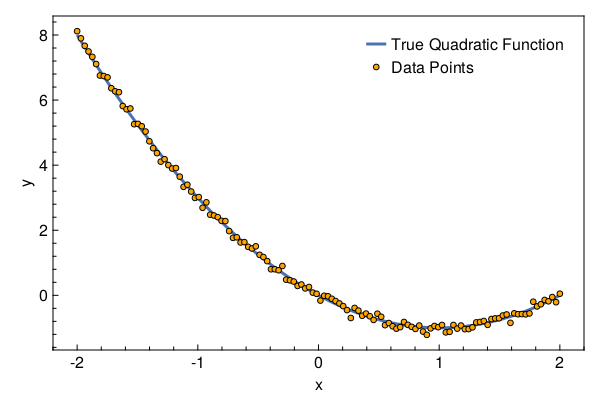

In [11]:
with_theme(theme_web()) do
    fig = Figure()
    ax = Axis(fig[1, 1]; xlabel="x", ylabel="y")

    l = lines!(ax, x[1, :], x -> evalpoly(x, (0, -2, 1)); linewidth=3)
    s = scatter!(ax, x[1, :], y[1, :]; markersize=8, color=:orange, strokecolor=:black,
                 strokewidth=1)

    axislegend(ax, [l, s], ["True Quadratic Function", "Data Points"])

    return fig
end

In [22]:
model = Chain(Dense(1 => 16, relu), Dense(16 => 1))

Chain(
    layer_1 = Dense(1 => 16, relu),     # 32 parameters
    layer_2 = Dense(16 => 1),           # 17 parameters
)         # Total: 49 parameters,
          #        plus 0 states, summarysize 32 bytes.

In [23]:
opt = Adam(0.03f0)

Adam{Float32}(0.03f0, (0.9f0, 0.999f0), 1.1920929f-7)

In [24]:
function loss_function(model, ps, st, data)
    y_pred, st = Lux.apply(model, data[1], ps, st)
    mse_loss = mean(abs2, y_pred .- data[2])
    return mse_loss, st, ()
end

loss_function (generic function with 1 method)

In [26]:
tstate = Lux.Training.TrainState(rng, model, opt)

Lux.Training.TrainState{NamedTuple{(:layer_1, :layer_2), Tuple{NamedTuple{(:weight, :bias), Tuple{Matrix{Float32}, Matrix{Float32}}}, NamedTuple{(:weight, :bias), Tuple{Matrix{Float32}, Matrix{Float32}}}}}, NamedTuple{(:layer_1, :layer_2), Tuple{NamedTuple{(), Tuple{}}, NamedTuple{(), Tuple{}}}}, NamedTuple{(:layer_1, :layer_2), Tuple{NamedTuple{(:weight, :bias), Tuple{Optimisers.Leaf{Adam{Float32}, Tuple{Matrix{Float32}, Matrix{Float32}, Tuple{Float32, Float32}}}, Optimisers.Leaf{Adam{Float32}, Tuple{Matrix{Float32}, Matrix{Float32}, Tuple{Float32, Float32}}}}}, NamedTuple{(:weight, :bias), Tuple{Optimisers.Leaf{Adam{Float32}, Tuple{Matrix{Float32}, Matrix{Float32}, Tuple{Float32, Float32}}}, Optimisers.Leaf{Adam{Float32}, Tuple{Matrix{Float32}, Matrix{Float32}, Tuple{Float32, Float32}}}}}}}, Chain{NamedTuple{(:layer_1, :layer_2), Tuple{Dense{true, typeof(relu), typeof(Lux.glorot_uniform), typeof(Lux.zeros32)}, Dense{true, typeof(identity), typeof(Lux.glorot_uniform), typeof(Lux.zeros

In [27]:
vjp_rule = Lux.Training.ZygoteVJP()

Lux.Training.ZygoteVJP()

In [28]:
function main(tstate::Lux.Training.TrainState, vjp::Lux.Training.AbstractVJP, data::Tuple,
              epochs::Int)
    data = data .|> gpu
    for epoch in 1:epochs
        grads, loss, stats, tstate = Lux.Training.compute_gradients(vjp, loss_function,
                                                                    data, tstate)
        @info epoch=epoch loss=loss
        tstate = Lux.Training.apply_gradients(tstate, grads)
    end
    return tstate
end

tstate = main(tstate, vjp_rule, (x, y), 250)
y_pred = cpu(Lux.apply(tstate.model, gpu(x), tstate.parameters, tstate.states)[1])

┌ Info: 1
└   loss = 7.014247884726132
┌ Info: 2
└   loss = 6.199052224710302
┌ Info: 3
└   loss = 5.431867803344194
┌ Info: 4
└   loss = 4.71665052628429
┌ Info: 5
└   loss = 4.0391475734470035
┌ Info: 6
└   loss = 3.4034054262905182
┌ Info: 7
└   loss = 2.8162562768353148
┌ Info: 8
└   loss = 2.2800398549556506
┌ Info: 9
└   loss = 1.7987329349652004
┌ Info: 10
└   loss = 1.3839927222356496
┌ Info: 11
└   loss = 1.0517920064548314
┌ Info: 12
└   loss = 0.8171528769579921
┌ Info: 13
└   loss = 0.6853986022587354
┌ Info: 14
└   loss = 0.6461365271451076
┌ Info: 15
└   loss = 0.6704624327805999
┌ Info: 16
└   loss = 0.715689622029831
┌ Info: 17
└   loss = 0.7365658478642403
┌ Info: 18
└   loss = 0.7081695438031976
┌ Info: 19
└   loss = 0.6307061341876852
┌ Info: 20
└   loss = 0.5202292335240193
┌ Info: 21
└   loss = 0.40580389945175316
┌ Info: 22
└   loss = 0.31855005039373524
┌ Info: 23
└   loss = 0.2802097979130727
┌ Info: 24
└   loss = 0.2917587533819065
┌ Info: 25
└   loss = 0.32829

┌ Info: 142
└   loss = 0.02296714014298281
┌ Info: 143
└   loss = 0.022627115575431886
┌ Info: 144
└   loss = 0.022302524959923985
┌ Info: 145
└   loss = 0.02199170666025917
┌ Info: 146
└   loss = 0.02169159370075282
┌ Info: 147
└   loss = 0.021394692116066046
┌ Info: 148
└   loss = 0.0211067870239288
┌ Info: 149
└   loss = 0.020827835182702276
┌ Info: 150
└   loss = 0.02055778627055938
┌ Info: 151
└   loss = 0.020296353532315254
┌ Info: 152
└   loss = 0.02004275219532633
┌ Info: 153
└   loss = 0.0197960562958814
┌ Info: 154
└   loss = 0.019556476775403224
┌ Info: 155
└   loss = 0.01932343334788339
┌ Info: 156
└   loss = 0.01909643444301876
┌ Info: 157
└   loss = 0.018875305127505067
┌ Info: 158
└   loss = 0.018659805847226804
┌ Info: 159
└   loss = 0.018450199433775336
┌ Info: 160
└   loss = 0.018246593167851235
┌ Info: 161
└   loss = 0.01804446660078482
┌ Info: 162
└   loss = 0.017845011103932096
┌ Info: 163
└   loss = 0.01765027161122005
┌ Info: 164
└   loss = 0.017460249112975383
┌

1×128 Matrix{Float32}:
 7.94573  7.78067  7.6156  7.45054  …  -0.209097  -0.175185  -0.141273

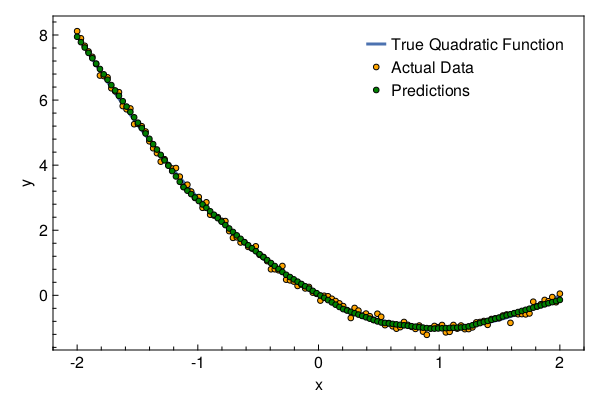

In [29]:
with_theme(theme_web()) do
    fig = Figure()
    ax = Axis(fig[1, 1]; xlabel="x", ylabel="y")

    l = lines!(ax, x[1, :], x -> evalpoly(x, (0, -2, 1)); linewidth=3)
    s1 = scatter!(ax, x[1, :], y[1, :]; markersize=8, color=:orange, strokecolor=:black,
                  strokewidth=1)
    s2 = scatter!(ax, x[1, :], y_pred[1, :]; markersize=8, color=:green, strokecolor=:black,
                  strokewidth=1)

    axislegend(ax, [l, s1, s2], ["True Quadratic Function", "Actual Data", "Predictions"])

    return fig
end